<a href="https://colab.research.google.com/github/andrew-veriga/sunpower/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_obs-planning.html

<!-- from astropy.coordinates import get_sun -->

##Получение данных из excel

In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

In [208]:
df.columns

Index(['№ п/п', 'Дата', 'Время', 'Мощность, МВт',
       'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
       'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
       'Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба) ',
       'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
       'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения ',
       'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ',
       'Общая облачность',
       'Текущая погода, сообщаемая с метеорологической станции ',
       'Прошедшая погода между сроками наблюдения 1',
       'Прошедшая погода между сроками наблюдения 2',
       'Слоисто-кучевые, слоитсые, кучевые и кучево-дожде

###Создание датасета

In [0]:
df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_9_Astrakhan_-_gotovo.xlsx", parse_dates=["Дата","Время"],infer_datetime_format=True, index_col=None)

# df['Location'] = 'Черный Яр'
# df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_5_Dosang_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата")
# df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_6_Kharabali_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата"))
# df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_7_Zelenga_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата"))
# df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_9_Astrakhan_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата"))

df['Время']= pd.to_timedelta(df['Время'].dt.hour, unit='h')
df['Дата'] = pd.to_datetime(df['Дата'].dt.date) + df['Время']# pd.to_timedelta(df['Время'].dt.hour, unit='h')


In [215]:
df=df.set_index('Дата').drop(columns=['№ п/п','Время'])
df.head()

,"Мощность, МВт",Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли,Атмосферное давление на уровне станции (миллиметры ртутного столба),"Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)",Относительная влажность (%) на высоте 2 метра над поверхностью земли,"Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения","Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду)",Общая облачность,"Текущая погода, сообщаемая с метеорологической станции",Прошедшая погода между сроками наблюдения 1,Прошедшая погода между сроками наблюдения 2,"Слоисто-кучевые, слоитсые, кучевые и кучево-дождевые облака","Количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдащихся облаков Cm",Высота основания самых низких облаков (м),"Высококучевые, высокослоистые и слоисто-дождевые облака","Перистые, перисто-кучевые и перисто-слоистые облака",Горизонтальная дальность видимости (км)
Дата,,,,,,,,,,,,,,,,,
2019-01-01 01:00:00,0.000000,0.7,772.4,770.4,84,67.5,2,100%.,Снег неливневый.,Снег или дождь со снегом.,Облака покрывали более половины неба в течение...,Слоистые разорванные или кучевые разорванные о...,70 – 80%.,300-600,Высокослоистые непросвечивающие или слоисто-до...,NaN,10
2019-01-01 04:00:00,0.000000,-0.2,772.5,770.5,90,67.5,1,100%.,Снег непрерывный умеренный в срок наблюдения.,Снег или дождь со снегом.,Облака покрывали более половины неба в течение...,Слоистые разорванные или кучевые разорванные о...,70 – 80%.,300-600,Высокослоистые непросвечивающие или слоисто-до...,NaN,2
2019-01-01 07:00:00,0.000000,-0.8,772.4,770.4,90,67.5,2,100%.,Снег непрерывный слабый в срок наблюдения.,Снег или дождь со снегом.,Облака покрывали более половины неба в течение...,Слоистые разорванные или кучевые разорванные о...,70 – 80%.,300-600,Высокослоистые непросвечивающие или слоисто-до...,NaN,4
2019-01-01 10:00:00,0.050111,-1.2,773.0,771.0,89,90.0,3,100%.,Дымка.,Снег или дождь со снегом.,Облака покрывали более половины неба в течение...,"Слоисто-кучевые, образовавшиеся не из кучевых.",100%.,600-1000,NaN,NaN,4
2019-01-01 13:00:00,1.187667,-0.5,772.1,770.1,87,67.5,2,100%.,Дымка.,Облака покрывали более половины неба в течение...,Облака покрывали более половины неба в течение...,"Слоисто-кучевых, слоистых, кучевых или кучево-...",100%.,"2500 или более, или облаков нет.",Высокослоистые просвечивающие.,NaN,4


'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли'

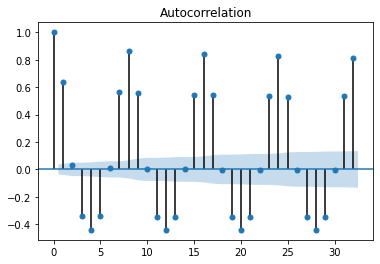

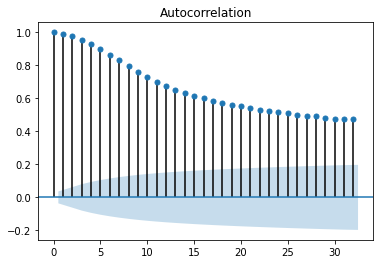

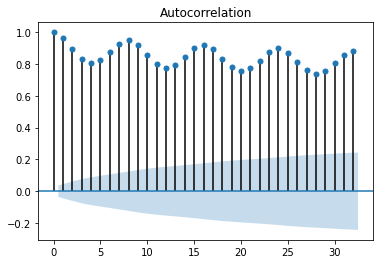

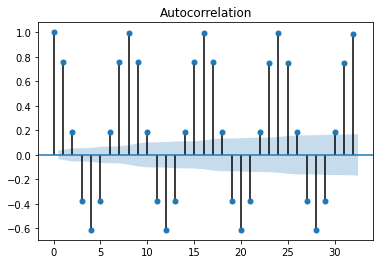

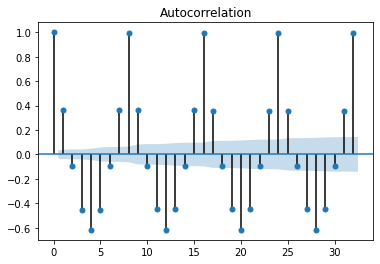

In [240]:
import astropy.units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
numeric_columns=[
            'Мощность, МВт',
            'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
            'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
            # 'Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба) ',
            'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
            'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения ',
            'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ',
            ]
#df['Время']=[pd.Timedelta(t,'h') for t in df['Время'].dt.hour]

series = df[numeric_columns].interpolate()# fillna(value=0)

# autocorrelation_plot(series)
# pyplot.show()            
# Черный яр : 48.060120° с.ш. 46.108620° в.д.
# Географические координаты Черного Яра. Широта : 48°03′44″ с.ш. Долгота: 46°06′32″ в.д. Высота над уровнем моря: 1 м.
# Астрахань 46.361433 48.060790
location = EarthLocation(lon=46.361433, lat= 48.060790, height=-20)
datetimes= Time(df.index)+4*u.hour
frame = AltAz(obstime=datetimes, location=location)
sun_altaz=get_sun(datetimes).transform_to(frame)

series['Sun_alt']= sun_altaz.alt
series['Sun_az'] = sun_altaz.az

lags = 32
size=(25, 9)
# pyplot.figure(figsize=(25, 9))
plot_acf(series['Мощность, МВт'], lags=lags)
plot_acf( series['Атмосферное давление на уровне станции (миллиметры ртутного столба)'], lags=lags)
plot_acf( series['Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли'], lags=lags)
plot_acf( series['Sun_alt'], lags=lags)
plot_acf( series['Sun_az'], lags=lags)
# pyplot.show()


In [0]:
   
# добавление one-hot векторов значений для колонок 'Общая облачность' и "Высота облаков"

clouds= df['Общая облачность'].astype('category')
clouds_height=df['Высота основания самых низких облаков (м)'].astype('category')
weather = df['Текущая погода, сообщаемая с метеорологической станции '].fillna(method= 'ffill').astype('category')
# weather_1 = df['Прошедшая погода между сроками наблюдения 1'].fillna(method= 'ffill').astype('category')
# weather_2 = df['Прошедшая погода между сроками наблюдения 2'].fillna(method= 'ffill').astype('category')

series=pd.concat([
                  series,
                  pd.get_dummies(clouds, prefix='Облака',dummy_na=True).fillna(value=0),
                  pd.get_dummies(clouds_height,prefix='Высота',dummy_na=True).fillna(value=0),
                  pd.get_dummies(weather,prefix='Погода')
                  # pd.get_dummies(weather_2,prefix='Погода2'),
                  # pd.get_dummies(weather_1,prefix='Погода1')
                  ],axis=1)              


#series.drop(columns=['Время'])
# # Добавление колонок "Время дня" и "Месяц года"
# series.insert(0,'Месяц', series.index.month)
# series.insert(1,'Время', series.index.hour)# series['Время'].map(lambda x: np.int(x.strftime('%H')))#.astype(np.string_)#.map(lambda x: x.strftime('%H'))

# нормализация данных
from sklearn.preprocessing import MinMaxScaler

norm_cols = numeric_columns
norm_cols.remove('Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения ')
series.loc[:, norm_cols] = series.loc[:, norm_cols].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
series.loc[:, norm_cols] = scaler.fit_transform(series.loc[:, norm_cols])

# norm_cols.remove('Мощность, МВт')

# data_mean= series.loc[:, norm_cols].mean(axis=0)
# data_std = series.loc[:, norm_cols].std(axis=0)
# series.loc[:, norm_cols] = (series.loc[:, norm_cols]-data_mean)/data_std
#автокорелляция данных
# series=series.corr()
###################




In [266]:
norm_cols

['Мощность, МВт',
 'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
 'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
 'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
 'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ']

проба из https://www.tensorflow.org/tutorials/structured_data/time_series

In [0]:
### проба из https://www.tensorflow.org/tutorials/structured_data/time_series
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)
######################################
# past_history = window_size
# future_target = 1
# STEP = 1
# ds= series.values
# target = series['Мощность, МВт'].values
# x_train_single, y_train_single = multivariate_data(ds, target, 0,
#                                                    split_datetime, past_history,
#                                                    future_target, STEP,
#                                                    single_step=True)

###Оформление оконного датасета

In [0]:
def windowed_dataset(series, target, window_size, batch_size, shuffle_buffer):
  target_col=series.columns.get_loc(target)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1,target_col]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
def make_splitdataset(df, split_pos):
  x_train = series[:split_pos]
  x_valid = series[split_pos:]

  ds_train = windowed_dataset(x_train, 'Мощность, МВт', window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
  ds_val = windowed_dataset(x_valid, 'Мощность, МВт', window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
  return ds_train, ds_val


##Сборка и тренировка модели

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-6 * 10**(epoch / 20))

def make_model(train_shape):
  m = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, train_shape]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40)),
      tf.keras.layers.Dense(1)
    ])

  
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=6e-5)
  m.compile(loss="mse", optimizer=optimizer, metrics=['mae', 'acc'])
  return m
  
def train_model(model, train, validation, epoch_num=50):
  history = model.fit(train, validation_data=(validation), epochs=epoch_num)#,callbacks=[lr_schedule])
  return history

In [0]:
tf.keras.backend.clear_session()
window_size = int(24/3*3)
batch_size = 120
shuffle_buffer_size = 1000
split_datetime = 2500




In [0]:
train, validation = make_splitdataset(series, split_datetime)
Model = make_model(series.shape[1])

In [288]:
series.shape

(2928, 230)

In [289]:

history = train_model(Model, train, validation,200)

Epoch 1/200
21/21 [==============================] - 2s 103ms/step - loss: 0.2003 - mae: 0.3278 - acc: 0.3518 - val_loss: 0.0363 - val_mae: 0.1350 - val_acc: 0.4975
Epoch 2/200
21/21 [==============================] - 1s 36ms/step - loss: 0.0847 - mae: 0.2348 - acc: 0.3518 - val_loss: 0.0266 - val_mae: 0.1425 - val_acc: 0.4975
Epoch 3/200
21/21 [==============================] - 1s 37ms/step - loss: 0.0547 - mae: 0.1860 - acc: 0.3518 - val_loss: 0.0194 - val_mae: 0.1157 - val_acc: 0.4975
Epoch 4/200
21/21 [==============================] - 1s 39ms/step - loss: 0.0352 - mae: 0.1397 - acc: 0.3518 - val_loss: 0.0199 - val_mae: 0.0937 - val_acc: 0.4975
Epoch 5/200
21/21 [==============================] - 1s 36ms/step - loss: 0.0263 - mae: 0.1172 - acc: 0.3518 - val_loss: 0.0262 - val_mae: 0.1207 - val_acc: 0.4975
Epoch 6/200
21/21 [==============================] - 1s 35ms/step - loss: 0.0228 - mae: 0.1061 - acc: 0.3522 - val_loss: 0.0179 - val_mae: 0.0923 - val_acc: 0.4975
Epoch 7/200
21/

In [0]:

 
# lrs = 1e-6 * (10 ** (np.arange(50) / 20))
# plt.semilogx(lrs, history.history["val_loss"][:])
# plt.axis([1e-6, 200, 0, 20])

###Анализ функции потерь

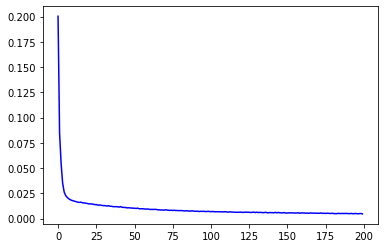

In [290]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[0.010270699858665466, 0.01001370046287775, 0.010327411815524101, 0.00975592341274023, 0.009696763940155506, 0.009749059565365314, 0.0095593286678195, 0.009417177177965641, 0.009475553408265114, 0.0094078304246068, 0.009059609845280647, 0.009051199071109295, 0.008969677612185478, 0.009008762426674366, 0.009090264327824116, 0.008773929439485073, 0.008572069928050041, 0.008481141179800034, 0.008556481450796127, 0.008320457302033901, 0.008587397634983063, 0.00853673368692398, 0.008278359659016132, 0.008135457523167133, 0.00823462475091219, 0.008036826737225056, 0.008240175433456898, 0.007925053127110004, 0.008048304356634617, 0.007854195311665535, 0.00793470349162817, 0.007892998866736889, 0.007700546178966761, 0.0075189596973359585, 0.007745410781353712, 0.00761805847287178, 0.007375878747552633, 0.0075777629390358925, 0.007629276253283024, 0.007304082158952951, 0.007217619568109512, 0.007392268627882004, 0.0069577982649207115, 0.007213301490992308, 0.007098237052559853, 0.00724559463560

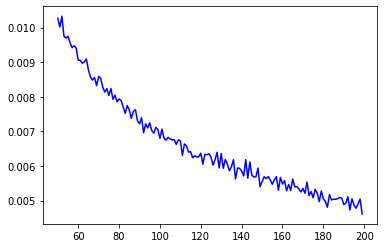

In [291]:
# Plot all but the first 10
loss = history.history['loss']
startpos= 50
epochs = range(50, len(loss))
plot_loss = loss[50:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

<Figure size 432x288 with 0 Axes>

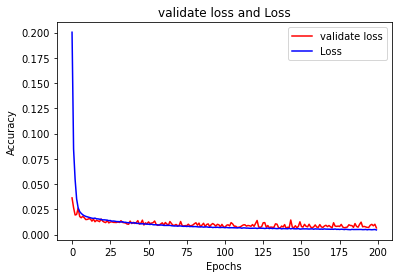

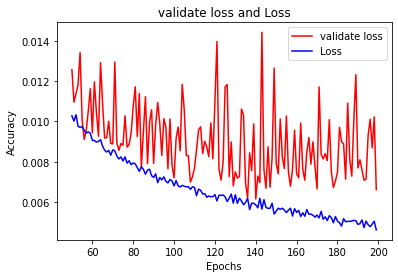

<Figure size 432x288 with 0 Axes>

In [292]:
val_loss=history.history['val_loss']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot validate loss and Loss
#------------------------------------------------
plt.plot(epochs, val_loss, 'r')
plt.plot(epochs, loss, 'b')
plt.title('validate loss and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["validate loss", "Loss"])

plt.figure()

epochs_zoom = epochs[50:]
mae_zoom = val_loss[50:]
loss_zoom = loss[50:]

#------------------------------------------------
# Plot Zoomed validate loss and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('validate loss and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["validate loss", "Loss"])

plt.figure()

### График сравнения предсказанной мощности с реальной, взятой из таблицы

In [0]:
# def windowed_dataset(series, target, window_size, batch_size, shuffle_buffer):
#   target_col=series.columns.get_loc(target)
#   dataset = tf.data.Dataset.from_tensor_slices(series)
#   dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
#   dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
#   dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1,target_col]))
#   dataset = dataset.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast.flatten()

In [277]:
test[window_size:]['Мощность, МВт'].shape

(404,)

In [278]:
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 16)          11056     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 80)          18240     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80)                38720     
_________________________________________________________________
dense (Dense)                (None, 1)                 81        
Total params: 68,097
Trainable params: 68,097
Non-trainable params: 0
_________________________________________________________________


In [298]:
from sklearn.metrics import mean_squared_error

forecast=model_forecast(Model, series[split_datetime-window_size:], window_size)
# invert scaling for forecast
test = pd.DataFrame(series[split_datetime:])
actuals = scaler.inverse_transform(test.loc[:, norm_cols].values)[:,0]
test['Мощность, МВт'] = forecast[:-1]
results = scaler.inverse_transform(test.loc[:, norm_cols].values)[:,0]
# calculate RMSE
rmse = mean_squared_error(actuals, results)
print('Test RMSE: %.3f' % rmse)
# invert scaling for actual
# test.loc[:, cols]=scaler.inverse_transform(test.loc[:, cols])
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]

# results = forecast
# results = np.squeeze(forecast)#[:, 0, 0]




Test RMSE: 0.007


In [280]:
forecast[1:].take(1)

0.017332938

In [281]:
(actuals.take(10),results.take(10))

(0.03126966208219528, 0.010929751209914684)

In [0]:
def plot_series(time, series, format="-", start=0, end=None, legend=None):
    plt.plot(time[start:end], series[start:end], format )
    plt.xlabel("Time")
    plt.ylabel("Value")
    # plt.legend(legend)
    plt.grid(True)

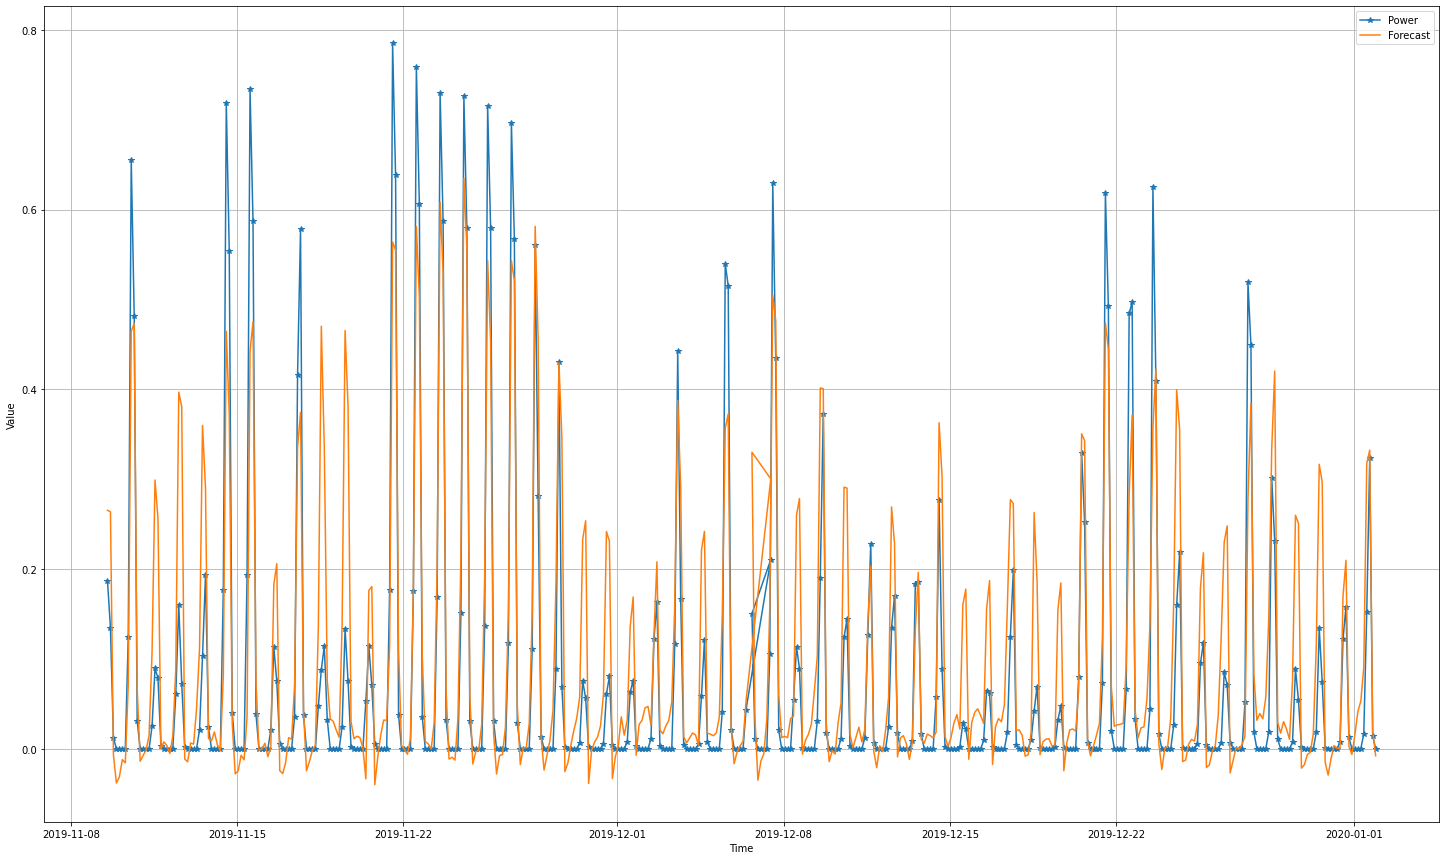

In [300]:
#import matplotlib.pyplot as plt

time_train = test.index#.to_numpy(dtype=np.datetime64)
plt.figure(figsize=(25, 15))
# plt.ylim(top=2)
plot_series(time_train, actuals, format='-*')#,start=200)#,end=200)
plot_series(time_train, results)#,start=200)#,end=200)
plt.legend(['Power', 'Forecast'])